In [1]:
import requests
import json
import math



#start with the usual imports
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import time
from rdkit import rdBase
print(time.asctime())
print(rdBase.rdkitVersion)
import numpy as np

Thu Jan 31 10:32:28 2019
2018.09.1


# Next few cells are just loading some molecules from ChEMBL

In [2]:
#some functions to make things go quicker:
#ChEMBL normally returns 1000 ligands max at a time. This loops through the rest of the ligands and returns the whole lot in a single list.
def getAllRecords(accession, pchembl, total_count):
    ligandList = []
    urlString = "https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=%s&pchembl_value__gt=%s&limit=%s" % (accession, pchembl, total_count)
    webQuery = json.loads(requests.get(urlString).content)
    activities = webQuery['activities']
    ligandList.extend(activities)
    numrepeats = math.ceil(float(total_count)/1000)
    while webQuery['page_meta']['next']:
        urlString = "https://www.ebi.ac.uk"+webQuery['page_meta']['next']
        webQuery = json.loads(requests.get(urlString).content)
        activities = webQuery['activities']
        ligandList.extend(activities)
        print('Loaded', len(ligandList), 'of', total_count)
    return(ligandList)

#this just makes a neater list with only the interesting things: CHEMBLID, common name, pchembl_value, smiles
def parseLigands(ligandList):
    newList = [(item['molecule_chembl_id'], item['molecule_pref_name'], item['pchembl_value'], item['canonical_smiles']) for item in ligandList]
    return(newList)

#this just groups multiple measurements together (into a list) for each ligand
def sortLigands(ligandList):
    newList = []
    chemblids = set([item[0] for item in ligandList])
    for id in chemblids:
        ligands = [item for item in ligandList if item[0]==id]
        newList.append(ligands)
    return(newList)

#this averages the pchembl values for all the measurements, for each ligand.
def averageLigands(ligandList):
    avgList = []
    for item in ligandList:
        if len(item)>1:
            allRecords = [float(measurement[2]) for measurement in item]
            avg = sum(allRecords) / len(allRecords)
            result = [(item[0][0], item[0][1], avg, item[0][3])]
        else:
            result = item
        avgList.append(result)
    return(avgList)

In [3]:
#getting ligands:

#This is a GABA receptor PROTEIN COMPLEX group from ChEMBL with several hundred buioactivity records
chembl_accession = 'CHEMBL2094130'

#equivalent to 10uM:
pchembl = 5

print('Counting bioactivities:')
urlString = "https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=%s&pchembl_value__gt=%s" % (chembl_accession, pchembl)
webQuery = json.loads(requests.get(urlString).content)
total_count = webQuery['page_meta']['total_count']
print(total_count)

ligandList = getAllRecords(chembl_accession, pchembl, total_count)
ligands = parseLigands(ligandList)
print('Of', len(ligands), 'ligand records,')
ligandsSorted = sortLigands(ligands)
print('got', len(ligandsSorted), 'unique ligands')
ligandsAveraged = averageLigands(ligandsSorted)
print('Averaged all', len(ligandsAveraged), 'ligands')

Counting bioactivities:
635
Of 635 ligand records,
got 494 unique ligands
Averaged all 494 ligands


In [4]:
from rdkit.Chem import SaltRemover
from rdkit.Chem import Descriptors

#smiles = [i[0] for i in ligandsAveraged]

remover = Chem.SaltRemover.SaltRemover(defnData="[Cl,Br,I,Ca,Zn,Li,Na,K,Mg,B,Ag]")

def sanitizeMols(ligands):
    saltmols = list()
    mols = list()
    for lig in ligands:
        try:
            mol = Chem.MolFromSmiles(lig[0][3])
            if mol:
                nosaltmol = remover.StripMol(mol)
                molwt = Chem.Descriptors.MolWt(nosaltmol)
                #removing peptides and small things
                if molwt<800 and molwt>90:
                    #Chem.RemoveHs(nosaltmol)
                    mols.append(nosaltmol)
        except:
            continue
    return mols

mols = sanitizeMols(ligandsAveraged)

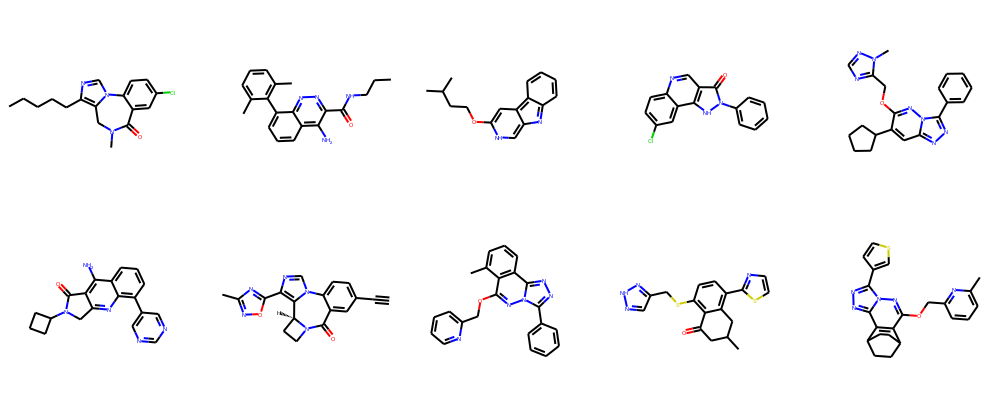

In [5]:
#quick sanitiy check:
import random
Draw.MolsToGridImage(random.sample(mols,10), molsPerRow=5)

# Time to fingerprint - AtomPair



In [6]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.AtomPairs import Pairs


atomInvariantsGen = rdFingerprintGenerator.GetMorganFeatureAtomInvGen()
gen = rdFingerprintGenerator.GetAtomPairGenerator(atomInvariantsGenerator=atomInvariantsGen)

In [7]:

normal_ap_fps = [Pairs.GetAtomPairFingerprintAsBitVect(i) for i in mols]

invariant_ap_fps = [gen.GetFingerprint(i) for i in mols]

Text(0,0.5,'AtomPair similarities w. invariants')

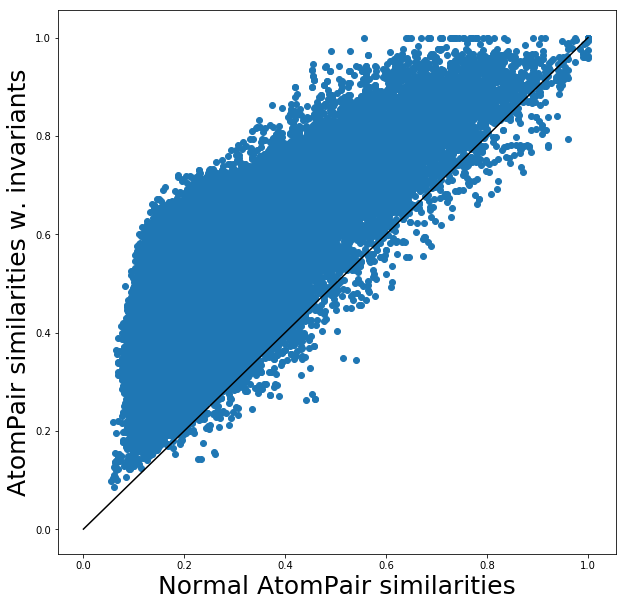

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

normal_ap_tc = [DataStructs.TanimotoSimilarity(x,y) for x,y in itertools.combinations(normal_ap_fps, 2)]
invariant_ap_tc = [DataStructs.TanimotoSimilarity(x,y) for x,y in itertools.combinations(invariant_ap_fps, 2)]

plt.figure(figsize=(10,10))
plt.scatter(normal_ap_tc, invariant_ap_tc)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), c='k')
plt.xlabel('Normal AtomPair similarities', fontsize=25)
plt.ylabel('AtomPair similarities w. invariants', fontsize=25)

# And topological torsion:

In [9]:
#atomInvariantsGen_tt = rdFingerprintGenerator.GetMorganFeatureAtomInvGen()
gen_tt = rdFingerprintGenerator.GetTopologicalTorsionGenerator(atomInvariantsGenerator=atomInvariantsGen)

In [12]:
from rdkit.Chem.AtomPairs import Torsions

normal_tt_fps = [Torsions.GetTopologicalTorsionFingerprintAsIntVect(i) for i in mols]
invariant_tt_fps = [gen_tt.GetFingerprint(i) for i in mols]

Text(0,0.5,'TT similarities w. invariants')

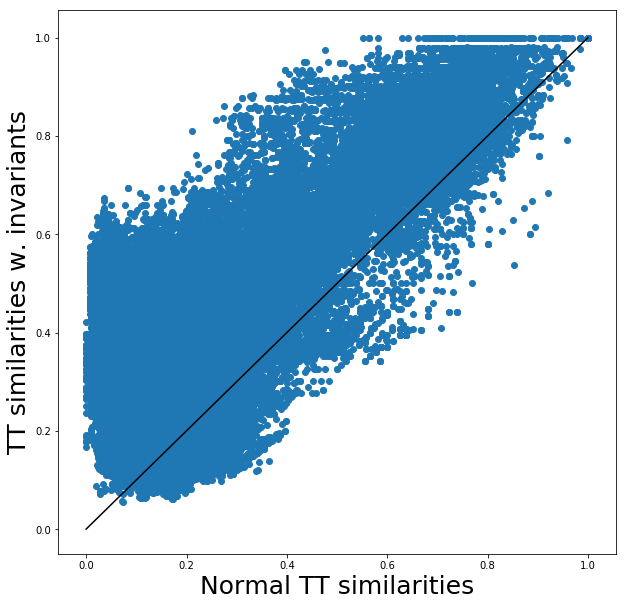

In [13]:
normal_tt_tc = [DataStructs.TanimotoSimilarity(x,y) for x,y in itertools.combinations(normal_tt_fps, 2)]
invariant_tt_tc = [DataStructs.TanimotoSimilarity(x,y) for x,y in itertools.combinations(invariant_tt_fps, 2)]

plt.figure(figsize=(10,10))
plt.scatter(normal_tt_tc, invariant_tt_tc)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), c='k')
plt.xlabel('Normal TT similarities', fontsize=25)
plt.ylabel('TT similarities w. invariants', fontsize=25)